# Snow drift potential

In [1]:
%matplotlib inline

In [2]:
import netCDF4
import numpy as np
import pylab as plt
plt.rcParams['figure.figsize'] = (14, 5)

Accessing netcdf file via thredds

The wind speeds in ...metcoop_default... are post-processed and based on FX (highest 10 min avergae within the hour). FX is in approximately about 10% higher than the hourly average.

In [3]:
ncdata = netCDF4.Dataset('http://thredds.met.no/thredds/dodsC/arome25/arome_metcoop_default2_5km_latest.nc')
x_wind_v = ncdata.variables['x_wind_10m'] # x component wrt the senorge grid - not true East!!!
y_wind_v = ncdata.variables['y_wind_10m'] # y component wrt the senorge grid -  not true North!!!

lat_v = ncdata.variables['latitude']
lon_v = ncdata.variables['longitude']

time_v = ncdata.variables['time']
t = netCDF4.num2date(time_v[:], time_v.units)

Calculating wind speed in one grid cell over the prognosis time


In [4]:
i_x = 200
i_y = 400
c_lat = lat_v[i_x,i_y]
c_lon = lon_v[i_x,i_y]
x_wind = x_wind_v[:,i_y,i_x]
y_wind = y_wind_v[:,i_y,i_x]
x_avg = np.mean(x_wind)
y_avg = np.mean(y_wind)
avg_wind_speed = np.sqrt(x_avg**2 + y_avg**2)

In [5]:
wind_speed = np.sqrt(x_wind**2 + y_wind**2)
wind_direction = np.arctan2(x_wind, y_wind) * 180 / np.pi
# using (x, y) results in N=0, W=-90, E=90, S=+/-180
# using (y, x) results in N=90, W=+/-180, E=0, S=-90
"""
The wind direction is most likely affected by the down scaling of the wind speed vectors; MET will provide a separate variable
of wind direction in the netcdf files on thredds that is related to the original 2.5 km resolution.
"""
st_threshold = 7.0 # (m/s); snow transport threshold varies depending on snow surface conditions
rel_wind_speed = np.where(wind_speed > st_threshold)
print(type(rel_wind_speed), len(rel_wind_speed), len(wind_speed))

<class 'tuple'> 1 67


Plotting wind speed


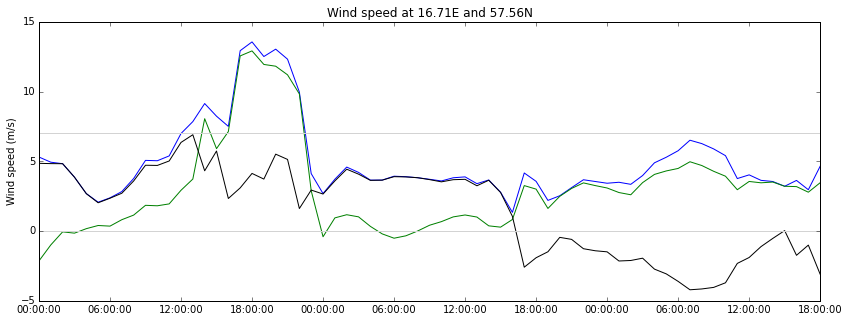

In [6]:
plt.figure()
plt.plot(t, wind_speed)
plt.plot(t, x_wind, label='x-wind', color='g')
plt.plot(t, y_wind, label='y-wind', color='k')
plt.axhline(y=0, color='lightgrey')
plt.axhline(y=st_threshold, color='lightgrey')
plt.ylabel('Wind speed (m/s)')
plt.title('Wind speed at {0:.2f}E and {1:.2f}N'.format(c_lon, c_lat))
plt.show()

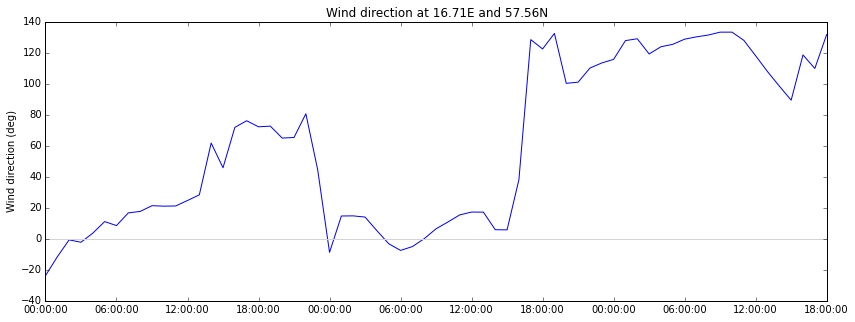

In [7]:
plt.figure()
plt.plot(t, wind_direction)
plt.axhline(y=0, color='lightgrey')
plt.ylabel('Wind direction (deg)')
plt.title('Wind direction at {0:.2f}E and {1:.2f}N'.format(c_lon, c_lat))
plt.show()

Cluster wind speeds depending on the standard variation of the wind direction (upper and lower limits) before applying a wind speed threshold.

In [35]:
def avg_wind_dir(uav, vav):
    if uav == 0:
        if vav == 0:
            return 0.0
        else:
            if vav > 0:
                return 360.0
            else:
                return 180.0
    else:
        if uav > 0:
            return 90.0-180.0 / np.pi * np.arctan(vav/uav) # had to swap 90 and 270 between if-else to get it right
        else:
            return 270.0-180.0 / np.pi * np.arctan(vav/uav)

See more at: http://www.weatherapi.net/calculate-average-wind-direction/#sthash.VhvKzU0S.dpuf

In [38]:
# test avg_wind_dir()
uav = np.array([1., 1., -1., -1., 0.0, 1.0, 0.0])
vav = np.array([1., -1., 1., -1., 1.0, 0.0, 0.0])
exp_res = [45.0, 135.0, 315.0, 225.0, 360.0, 90.0, 0.0]

res = [avg_wind_dir(u, v) for u, v in zip(uav, vav)]
print(res, res==exp_res)

[45.0, 135.0, 315.0, 225.0, 360.0, 90.0, 0.0] True


In [47]:
u = np.array([-10., 10., -10.])
v = np.array([1., -1., -1.])
res = [avg_wind_dir(x, y) for x, y in zip(u, v)]
print(res)
uav = np.mean(u)
vav = np.mean(v)
avg_dir = avg_wind_dir(uav, vav)
print(uav, vav, avg_dir)

[275.71059313749964, 95.710593137499643, 264.28940686250036]
-3.33333333333 -0.333333333333 264.289406863


## Defining drift potential

See [Gompertz function](https://en.wikipedia.org/wiki/Gompertz_function)


In [9]:
def drift_potential(u, a=1.2, b=15, c=.16):
    '''
    Using a Gompertz function (subclass of sigmoid functions) to resample the experimental derived snow transport curve by
    Föhn et al. 1980 of the form 8e-5 * u^3.
    
    u: wind speed in m/s
    a: is an asymptote; something like maximum possible additional snow depth
    b: defines the displacment along the x-axis; kind of a delay before snow transport starts;
        snow surface hardness will influence 'b'
    c: defines the growth rate; a measure for how quickly snow transport increases with increasing wind speeds;
        snow surface ahrdness and concurrent snow fall will influence 'c'
    
    Default values for 'a', 'b', and 'c' represent best fit to Föhn's model.
    
    TODO:
    - link a, b, and c to snow surface conditions available from the seNorge model.
    '''
    
    # Additional loading by wind redistribution on leeward slopes
    hs_wind_foehn = 8e-5 * u**3.0
    hs_wind = a * np.exp(-b * np.exp(-c * u))
    return hs_wind, hs_wind_foehn

Comparison to Föhn's model:


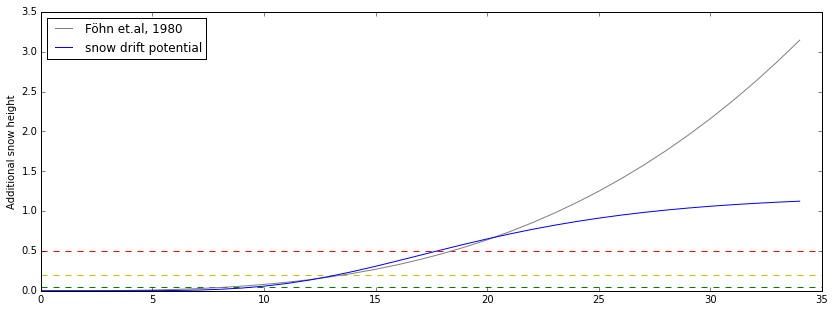

In [10]:
dummy_wind = np.arange(0,35) # m/s
dummy_hs, hs_foehn = drift_potential(dummy_wind, a=1.2, b=15, c=.16)
plt.figure()
plt.axhline(y=0.05, linestyle='--', color='g') # lower limit for little snow transport
plt.axhline(y=0.2, linestyle='--', color='y') # lower limit for intermediate snow transport
plt.axhline(y=0.5, linestyle='--', color='r') # lower limit for severe snow transport
plt.plot(dummy_wind, hs_foehn, color='0.5', label='Föhn et.al, 1980')
plt.plot(dummy_wind, dummy_hs, label='snow drift potential')
plt.ylabel('Additional snow height')
plt.legend(loc=2)
plt.show()

Using real data from AROME model


In [11]:
hs_wind, hsf = drift_potential(wind_speed)

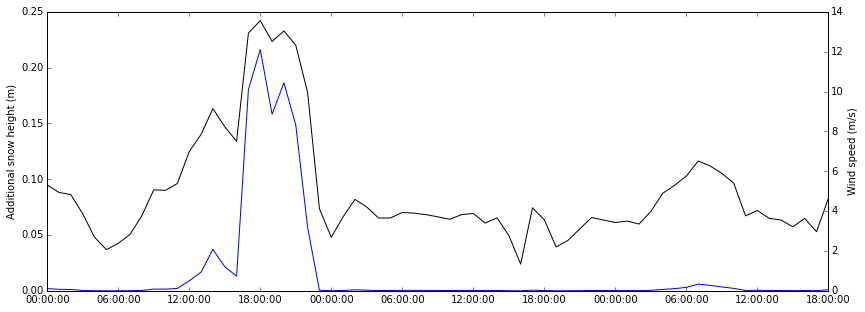

In [12]:
plt.figure()
plt.plot(t, hs_wind)
plt.ylabel('Additional snow height (m)')
ax_wind = plt.gca().twinx()
ax_wind.plot(t, wind_speed, color='k')
ax_wind.set_ylabel('Wind speed (m/s)')
plt.show()

## TODO: Need to sum up over a certain time period - check which time period Föhn uses. 